In [1]:
import sys
sys.path.insert(0, '/home/mhg19/Manuscripts/PNAS19/network')

In [290]:
import numpy as np
import scipy
from tqdm import trange
from numba import njit, jit

In [3]:
from network import Population, RateNetwork
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity

OU Input

In [308]:
N = 40000
c = 0.005
K = c*N
T = 0.16
t_Delta_t = 10e-3

# Discretization to use
dt = 1e-3
n_Delta_t = int(t_Delta_t/dt)
n_T = int(T/dt)
xi = np.zeros((N,n_T))

# Underlying OU process
tau_ou = 4e-3
dt_ou = 1e-5
sigma_ou = 1 * np.sqrt(2/tau_ou)
n_T_ou = int(T/dt_ou)
xi_t = rng.randn(N)
xi_t_1 = np.zeros_like(xi_t)
np.random.seed(seed=0)

@njit
def func(xi, xi_t, xi_t_1):
    for n in range(n_T_ou-1):
        if n % 100:
            xi[:,int(n/100)] = xi_t
        if n > 0:
            xi_t[:] = xi_t_1[:]
        xi_t_1[:] = (1 - dt_ou/tau_ou)*xi_t + sigma_ou*np.sqrt(dt_ou)*np.random.randn(N)

func(xi, xi_t, xi_t_1)

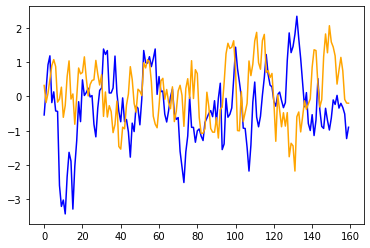

In [317]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xi[0], color='blue');
plt.plot(xi[1], color='orange');

In [319]:
#phi = ErrorFunction(mu=0.22, sigma=0.2).phi
theta, sigma = 0.14, 0.1
phi = ErrorFunction(mu=theta, sigma=sigma).phi
exc = Population(N=N, tau=1e-2, phi=phi)
conn = SparseConnectivity(exc, exc, p=0.005)
conn.set_all(1)
conn.W.data[:] = 0
conn.W = conn.W.tocoo()

In [320]:
ij = conn.ij
ji = [[] for _ in range(N)] # ji[row_idx] = col_idxs_sorted
for col_idx, row_idxs in enumerate(ij):
    for row_idx in row_idxs:
        ji[row_idx].append(col_idx)
a = np.cumsum([0]+[len(d) for d in ji])
b = np.hstack(ji)

Bilinear rule w/ homeostatic normalization

In [321]:
from numba import njit, prange

In [322]:
data = np.zeros(b.size)

@njit
def func(dJ):
    def g(x):
        return x
    def f(x):
        return x
    for i in prange(N):
        j = b[a[i]:a[i+1]]
        for n in range(10,n_T):
            #g_avg = np.mean(g(xi[j,n-10]))
            g_avg = 0
            dw = f(xi[:,n][i])*(g(xi[j,n-10]-g_avg))
            dJ[slice(a[i],a[i+1])] += dw
func(data)
data /= K*n_Delta_t
conn.W.data[:] = data

Bilinear rule (no homeostatic normalization)

In [323]:
#f = lambda x: x
#g = lambda x: x
#row = []
#col = []
#data = []
#for j in trange(N):
#    i = ij[j]
#    w = np.sum(f(xi[i,n_Delta_t:]) * g(xi[j,:-n_Delta_t][np.newaxis,:]), axis=1)
#    row.extend(i)
#    col.extend([j]*len(i))
#    data.extend(w)
#data = np.asarray(data)
#W = scipy.sparse.coo_matrix((data/K/n_Delta_t, (row, col)), dtype=np.float32)
#conn.W = W.tocsr()

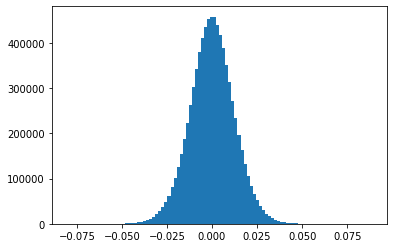

In [324]:
plt.hist(conn.W.data, bins=100);

In [325]:
net = RateNetwork(exc, c_EE=conn, formulation=1)
def g(x):
    return x
def f(x):
    return x
r0 = exc.phi(f(xi[:,0]))
net.simulate(T*2, r0=r0)

[========================================================================] 100%


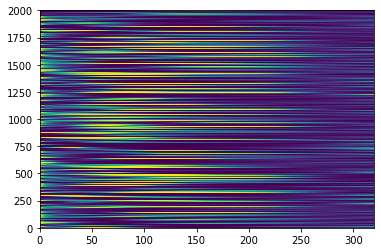

In [326]:
plt.pcolormesh(net.exc.state[::20,:]);

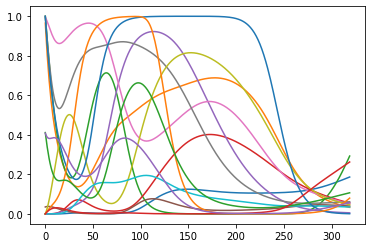

In [327]:
for n in range(15):
    plt.plot(net.exc.state[n,:]);

In [328]:
overlaps = np.zeros((16,300))
for n in range(16):
    overlaps[n,:] = np.mean(xi[:,n*10][:,np.newaxis]*net.exc.state[:,:300], axis=0)

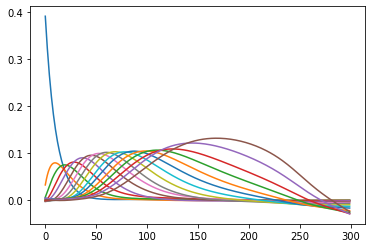

In [329]:
for overlap in overlaps:
    plt.plot(overlap);

In [330]:
from scipy.stats import pearsonr

In [331]:
correlations = np.zeros((16,300))
for n in trange(16):
    for t in range(300):
        correlations[n,t] = pearsonr(
            xi[:,n*10], net.exc.state[:,t])[0]

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


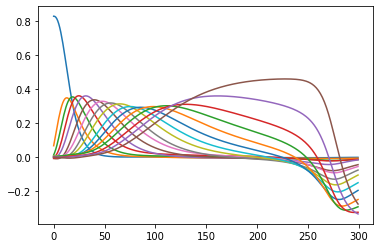

In [332]:
for overlap in correlations:
    plt.plot(overlap);

In [333]:
np.save("data/data.npy", {
    'overlaps': overlaps,
    'correlations': correlations,
    'state': net.exc.state,
    'xi': xi,
    'phi': {
        'theta': theta,
        'sigma': sigma,
    }
})